In [1]:
"""
TMD Library Demo - Comprehensive demonstration of TMD library features.

This script demonstrates:
1. Creating and reading TMD files
2. Height map manipulations (crop, rotate, threshold, etc.)
3. Gaussian filtering
4. Cross-section extraction
5. Various export formats (STL, NumPy, images)
"""


'\nTMD Library Demo - Comprehensive demonstration of TMD library features.\n\nThis script demonstrates:\n1. Creating and reading TMD files\n2. Height map manipulations (crop, rotate, threshold, etc.)\n3. Gaussian filtering\n4. Cross-section extraction\n5. Various export formats (STL, NumPy, images)\n'

In [2]:

import os
import numpy as np
import matplotlib.pyplot as plt

from tmd.processor import TMDProcessor
from tmd.utils.utils import generate_synthetic_tmd, create_sample_height_map
from tmd.utils.processing import (
    crop_height_map, rotate_height_map, threshold_height_map, 
    extract_cross_section, extract_profile_at_percentage
)
from tmd.utils.filter import apply_gaussian_filter
from tmd.exporters.numpy import export_to_npy, export_to_npz, export_metadata_txt
from tmd.exporters.image import (
    convert_heightmap_to_displacement_map, convert_heightmap_to_normal_map,
    convert_heightmap_to_bump_map, convert_heightmap_to_ao_map
)
from tmd.exporters.stl import convert_heightmap_to_stl
from typing import Tuple, Optional
from tmd.plotters.matplotlib import (
    plot_height_map_matplotlib
)


In [3]:

try:
    from tmd.plotters.plotly import plot_height_map_3d, plot_cross_section_plotly
    has_plotly = True
except ImportError:
    has_plotly = False



In [4]:
# ------------------ STEP FUNCTIONS ------------------

def generate_and_process_tmd(output_dir):
    """
    Generates a synthetic TMD file and processes it.
    
    Returns:
        data (dict): Processed metadata and height map.
        tmd_path (str): Path to the generated TMD file.
    """
    print("\nStep 1: Generating synthetic TMD file...")
    tmd_path = os.path.join(output_dir, "sample.tmd")
    # Assuming generate_synthetic_tmd now accepts parameters for width, height, pattern, etc.
    tmd_path = generate_synthetic_tmd(
        output_path=tmd_path,
        width=201,
        height=200,
        pattern="combined",
        comment="Created by TrueMap v6",
        version=2
    )
    print(f"Created TMD file at: {tmd_path}")

    print("\nStep 2: Processing TMD file...")
    processor = TMDProcessor(tmd_path)
    processor.set_debug(True)
    data = processor.process()

    if not data:
        print("Failed to process TMD file. Using synthetic height map directly.")
        height_map = create_sample_height_map(width=201, height=200, pattern="combined")
        data = {
            'height_map': height_map,
            'width': height_map.shape[1],
            'height': height_map.shape[0],
            'x_length': 10.0,
            'y_length': 10.0,
            'x_offset': 0.0,
            'y_offset': 0.0,
            'comment': 'Synthetic height map',
            'header': 'Synthetic TMD'
        }
    return data, tmd_path



In [5]:

def visualize_raw_height_map(height_map, output_dir):
    """
    Visualizes and saves the raw height map as a PNG image.
    """
    print("\nStep 3: Visualizing raw height map...")
    plt.figure(figsize=(10, 8))
    plt.imshow(height_map, cmap='viridis')
    plt.colorbar(label='Height')
    plt.title('Raw Height Map')
    out_path = os.path.join(output_dir, 'raw_height_map.png')
    plt.savefig(out_path, dpi=300)
    plt.close()
    print(f"Saved raw height map to {out_path}")



In [6]:

def manipulate_height_map_demo(height_map, output_dir, data):
    """
    Demonstrates cropping, rotation, and thresholding on the height map.
    """
    print("\nStep 4: Demonstrating height map manipulation operations...")

    # 4.1 Cropping: extract the middle 50% region.
    rows, cols = height_map.shape
    crop_region = (rows // 4, 3 * rows // 4, cols // 4, 3 * cols // 4)
    cropped_map = crop_height_map(height_map, crop_region)
    out_path = os.path.join(output_dir, 'cropped_height_map.png')
    plt.figure(figsize=(10, 8))
    plt.imshow(cropped_map, cmap='viridis')
    plt.colorbar(label='Height')
    plt.title('Cropped Height Map')
    plt.savefig(out_path, dpi=300)
    plt.close()
    print(f"Cropped height map saved to {out_path}")

    # 4.2 Rotation: rotate by 45 degrees.
    rotated_map = rotate_height_map(height_map, angle=45)
    out_path = os.path.join(output_dir, 'rotated_height_map.png')
    plt.figure(figsize=(10, 8))
    plt.imshow(rotated_map, cmap='viridis')
    plt.colorbar(label='Height')
    plt.title('Rotated Height Map (45°)')
    plt.savefig(out_path, dpi=300)
    plt.close()
    print(f"Rotated height map saved to {out_path}")

    # 4.3 Thresholding: keep the middle 60% of height values.
    h_min, h_max = height_map.min(), height_map.max()
    h_range = h_max - h_min
    min_threshold = h_min + 0.2 * h_range
    max_threshold = h_max - 0.2 * h_range
    thresholded_map = threshold_height_map(height_map, min_height=min_threshold, max_height=max_threshold)
    out_path = os.path.join(output_dir, 'thresholded_height_map.png')
    plt.figure(figsize=(10, 8))
    plt.imshow(thresholded_map, cmap='viridis')
    plt.colorbar(label='Height')
    plt.title(f'Thresholded Height Map ({min_threshold:.2f} - {max_threshold:.2f})')
    plt.savefig(out_path, dpi=300)
    plt.close()
    print(f"Thresholded height map saved to {out_path}")



In [7]:

def gaussian_filter_demo(height_map, output_dir):
    """
    Applies a Gaussian filter to the height map and saves the result.
    """
    print("\nStep 5: Applying Gaussian filter...")
    smoothed_map = apply_gaussian_filter(height_map, sigma=2.0)
    out_path = os.path.join(output_dir, 'smoothed_height_map.png')
    plt.figure(figsize=(10, 8))
    plt.imshow(smoothed_map, cmap='viridis')
    plt.colorbar(label='Height')
    plt.title('Gaussian Smoothed Height Map (sigma=2.0)')
    plt.savefig(out_path, dpi=300)
    plt.close()
    print(f"Smoothed height map saved to {out_path}")



In [8]:

def cross_section_demo(height_map, data, output_dir):
    """
    Extracts and plots a cross-section from the height map.
    """
    print("\nStep 6: Extracting cross-section...")
    x_position = height_map.shape[0] // 2
    x_positions, x_heights = extract_cross_section(height_map, data, axis='x', position=x_position)
    out_path = os.path.join(output_dir, 'x_cross_section.png')
    plt.figure(figsize=(10, 6))
    plt.plot(x_positions, x_heights, 'b-')
    plt.title(f'X Cross-Section at Row {x_position}')
    plt.xlabel('X Position (mm)')
    plt.ylabel('Height')
    plt.grid(True, alpha=0.3)
    plt.savefig(out_path, dpi=300)
    plt.close()
    print(f"Cross-section saved to {out_path}")
    return x_position



In [9]:

def profile_demo(height_map, data, output_dir):
    """
    Extracts a profile at a specified percentage along the X axis, saves and plots it.
    """
    print("\nStep 7: Extracting profile at 75% position...")
    profile = extract_profile_at_percentage(height_map, data, axis='x', percentage=75.0,
                                            save_path=os.path.join(output_dir, 'profile_75_percent.npy'))
    out_path = os.path.join(output_dir, 'profile_75_percent.png')
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(profile)), profile, 'r-')
    plt.title('Profile at 75% along Y-axis')
    plt.xlabel('X Position (pixels)')
    plt.ylabel('Height')
    plt.grid(True, alpha=0.3)
    plt.savefig(out_path, dpi=300)
    plt.close()
    print(f"Profile extracted and saved to {out_path}")



In [10]:

def export_formats_demo(height_map, data, output_dir):
    """
    Exports height map data to various formats: NumPy arrays, metadata text, image maps, STL.
    """
    print("\nStep 8: Demonstrating export options...")
    # 8.1 Export to NumPy formats
    npy_path = export_to_npy(height_map, os.path.join(output_dir, 'height_map.npy'))
    npz_path = export_to_npz(data, os.path.join(output_dir, 'tmd_data.npz'))
    txt_path = export_metadata_txt(data, os.path.join(output_dir, 'metadata.txt'))
    print(f"Exported NumPy formats: {npy_path}, {npz_path}")
    print(f"Exported metadata to {txt_path}")

    # 8.2 Export as image maps
    convert_heightmap_to_displacement_map(height_map, os.path.join(output_dir, 'displacement_map.png'))
    convert_heightmap_to_normal_map(height_map, os.path.join(output_dir, 'normal_map.png'))
    convert_heightmap_to_bump_map(height_map, os.path.join(output_dir, 'bump_map.png'))
    # AO map: use a downsampled version for performance
    small_height_map = height_map[::4, ::4]
    convert_heightmap_to_ao_map(small_height_map, os.path.join(output_dir, 'ao_map.png'), samples=8)
    print("Exported image maps.")

    # 8.3 Export as STL
    stl_path = os.path.join(output_dir, 'height_map_ascii.stl')
    convert_heightmap_to_stl(
        height_map,
        filename=stl_path,
        x_length=data['x_length'],
        y_length=data['y_length'],
        z_scale=2.0,
        ascii=True
    )
    binary_stl_path = os.path.join(output_dir, 'height_map_binary.stl')
    convert_heightmap_to_stl(
        height_map,
        filename=binary_stl_path,
        x_length=data['x_length'],
        y_length=data['y_length'],
        z_scale=2.0,
        ascii=False
    )
    print(f"Exported STL files: {stl_path}, {binary_stl_path}")



In [11]:

def advanced_visualizations_demo(height_map, data, output_dir, x_position):
    """
    Creates advanced visualizations using Plotly and matplotlib.
    """
    print("\nStep 9: Creating advanced visualizations with Plotly...")
    plot_height_map_3d(
            height_map, 
            title="3D Surface Plot of Height Map",
            filename=os.path.join(output_dir, "height_map_3d.html")
    )
    
    print("\nCreating 3D surface plot with matplotlib...")
    plot_height_map_matplotlib(
        height_map,
        colorbar_label="Height (normalized)",
        filename=os.path.join(output_dir, "height_map_3d_matplotlib.png")
    )
    print("Advanced visualizations complete.")

In [12]:

# ------------------ MAIN DEMO FUNCTION ------------------

def main():
    """Main demonstration function showcasing TMD library capabilities."""
    output_dir = "output"
    os.makedirs(output_dir, exist_ok=True)
    
    print("=" * 80)
    print("TMD (TrueMap Data) Library Demonstration")
    print("=" * 80)
    
    # Generate and process TMD file
    data, tmd_path = generate_and_process_tmd(output_dir)
    height_map = data['height_map']
    
    # Visualize raw height map
    visualize_raw_height_map(height_map, output_dir)
    
    # Height map manipulation
    manipulate_height_map_demo(height_map, output_dir, data)
    
    # Gaussian filter demonstration
    gaussian_filter_demo(height_map, output_dir)
    
    # Cross-section extraction
    x_position = cross_section_demo(height_map, data, output_dir)
    
    # Profile extraction at a specific percentage
    profile_demo(height_map, data, output_dir)
    
    # Export to various formats
    export_formats_demo(height_map, data, output_dir)
    
    # Advanced visualizations (if Plotly is available)
    advanced_visualizations_demo(height_map, data, output_dir, x_position)
    
    print("\n" + "=" * 80)
    print("Demonstration complete! Output files are in the 'output' directory.")
    print("=" * 80)
    print("\nHere's a summary of the files created:")
    print("  - Height maps: raw, cropped, rotated, thresholded, smoothed")
    print("  - Cross-sections and profiles")
    print("  - Export formats:")
    print("    - NumPy files, metadata, image maps (displacement, normal, bump, AO)")
    print("    - 3D models: STL (ASCII & Binary)")
    print("    - Visualizations: PNG images and HTML files")


TMD (TrueMap Data) Library Demonstration

Step 1: Generating synthetic TMD file...
Writing TMD file v2 to output\sample.tmd
Remaining header: 2
Remaining comment: 2
Writing TMD file v2 to output\sample.tmd
Dimensions: 201 x 200, Spatial info: 10.0, 10.0, 0.0, 0.0
Successfully wrote TMD file: output\sample.tmd
File size: 160880 bytes
Created TMD file at: output\sample.tmd

Step 2: Processing TMD file...
⚠️ Detected v2 file format. Reading metadata...
Comment: Created by TrueMap v6
  
Width: 201, Height: 200
Width: 201, Height: 200
X Length: 10.0, Y Length: 10.0
X Offset: 0.0, Y Offset: 0.0

Step 3: Visualizing raw height map...
Saved raw height map to output\raw_height_map.png

Step 4: Demonstrating height map manipulation operations...
Cropped height map saved to output\cropped_height_map.png
Rotated height map saved to output\rotated_height_map.png
Thresholded height map saved to output\thresholded_height_map.png

Step 5: Applying Gaussian filter...
Smoothed height map saved to output

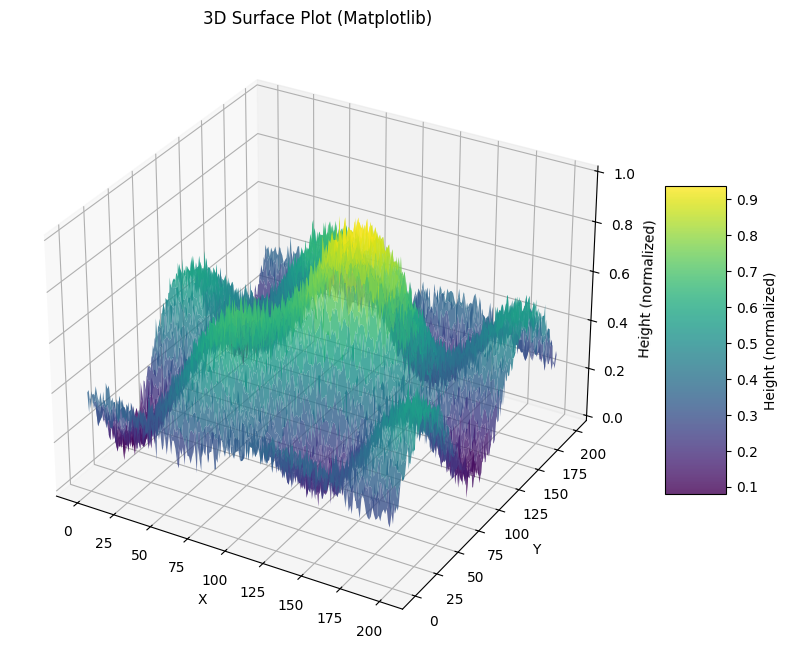

In [13]:

if __name__ == "__main__":
    main()
